This notebook implements the simple linear regression via the old fashioned way, and then by gradient descent.
- [Simple Linear Regression](#simple-linear-regression)
- [Simple Linear Regression via Gradient Descent](#Simple-Linear-Regression-via-Gradient-Descent)

In [27]:
import numpy as np

# for plots, cause visuals
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# the data

First, we need data:

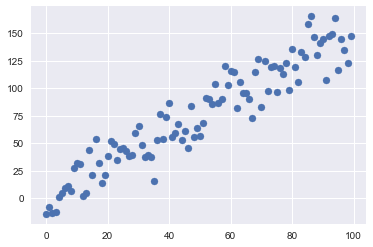

In [17]:
x_points = np.arange(0,100)
y_points = x_points*1.5 + np.random.normal(size=len(x_points))*15 #np.random.randint(0,40,len(x))
plt.scatter(x_points,y_points);

# simple linear regression

Since this is a simple 1 variable regression, the solution will be `y = mx + b` where y are the predicted points, m is the gradient of the line and b is the y-intercept.

So a first a helper function to return predicted values given a lines `m` and `b`:

In [5]:
def predict(x, m=0, b=0):
    """takes in array or list x, gradient m and y-intercept b 
    and returns a list of preddicted values"""
    return [m*point + b for point in x]

Now another function to calculate the regression error. We minus the prediction from actual values and square them (so negatives and pluses don't cancel out) and add them all up.

In [18]:
def regression_error(m, b, x, y):
    """takes in gradient m and y-intercept b and 
    arrays x and y which are the actual datapoints and returns cost"""
    cost = 0
    preds = predict(x, m, b)
    for i in range(len(x)):
        cost += (y[i] - preds[i]) ** 2 
    return cost

regression_error(m=0.1, b=0.2, x=x_points, y=y_points)

690697.73789037031

Lets eyeball a guessed a regression line vs the actual data:

Total Error: 195,382.52


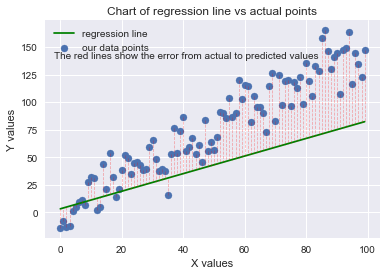

In [19]:
def plot(x, y, Ypreds):
    """takes in data points x,y and regression line predictions Ypreds
    and draws a scatter plot of x,y, the regression line X,Y
    and then draws a line from each point x,y and x,Ypreds"""
    
    plt.title("Chart of regression line vs actual points")
    # plot scatter plot of actual values
    plt.scatter(x, y, label="our data points");
    
    # plot the regression line
    plt.plot(x, Ypreds, label="regression line", color="g")
    
    # plot line from points to regression line to show diff
    # there must be faster way to do this instead of a for loop
    for i in range(len(x)):
        x1, y1 = [x[i], x[i]], [y[i], Ypreds[i]]
        plt.plot(x1,y1, color="r", alpha=0.3, linewidth=0.8, linestyle="dashed")
    
    plt.text(-2,140,"The red lines show the error from actual to predicted values", fontsize=10)
    plt.xlabel("X values"), plt.ylabel("Y values")
    plt.legend()
    plt.show()
    
# lets look at a sample regression line with m=0.8 and b=0.3
print(f"Total Error: {regression_error(0.8, 0.3, x_points, y_points):,.2f}")
plot(x_points, y_points, predict(x_points, 0.8 ,3))

It's pretty clear visually that my eyeballed line of best fit could defintely be better.

Since this is a simple linear regression, the solution will be a line `y=mx + b` where m is the slope of the line and b is the y intercept. Now we can math the solution quite easily as per [wikipedia](https://en.wikipedia.org/wiki/Simple_linear_regression) and [khan academy](https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data/more-on-regression/v/regression-line-example):

Total Error: 23,065.05
Gradient 1.520, Intercept 0.578


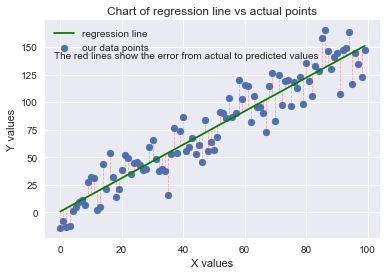

In [20]:
def simple_linear_regression_closed_form(x,y):
    """takes arrays of x,y and returns gradient m and y-intercept b"""
    # calculating all the variables we need
    # see https://en.wikipedia.org/wiki/Simple_linear_regression for equation
    n = len(x)
    xhat = np.mean(x) # avg of all the x points
    yhat = np.mean(y) # avg of all the y points
    xyhat = np.mean(np.array(x) * np.array(y)) # avg of all the x*y points
    xsqrhat = np.mean(np.array(x)**2) # avg of all the x squared points
    
    # now applying the formulas to get m and b
    m = (xhat*yhat - xyhat) / (xhat**2 - xsqrhat)
    b = yhat - m * xhat
    return m,b

m, b = simple_linear_regression_closed_form(x_points,y_points)
print(f"Total Error: {regression_error(m, b, x_points, y_points):,.2f}")
print(f"Gradient {m:.3f}, Intercept {b:.3f}")
plot(x_points, y_points, predict(x_points,m,b))

Hot diggity damn, it looks pretty good! now to double check this plot by comparing it to seaborn's built in regression function:

In [12]:
npM, npB = np.polyfit(x_points, y_points, 1)
print(f"Numpy solution returns gradient {npM:.3f} and y-intercept {npB:.3f}\
      Cost: {regression_error(npM, npB, x_points, y_points):,.2f}")
sns.regplot(x_points, y_points)
plt.title("Seaborn regression plot to check my version");

Numpy solution returns gradient 1.451 and y-intercept 3.863      Cost: 20,071.62


All right! The answers are exactly the same! So moving on to gradient descent:

# Simple Linear Regression via Gradient Descent

Gradient descent finds the solution by descending towards the right number. In this case where we're doing simple linear regression, we are trying to find the gradient and y-intercept of a (the famous `y = mx + b` equation) such that it minimizes the cost of that line.

So here, we start of with the simplest possible line where m and b are both 0, calculate the slope at that x position, and change x in the opposite direction of the slope, i.e `x = x - slope`. We keep doing that untill the slope is zero.

So heres the data and our starting line:

In [13]:
print(f"The error: {regression_error(0, 0, x_points, y_points):,.3f}")
plot(x_points, y_points, predict(x_points, m=0, b=0))

The error: 768,329.739


So it's obvious our line is very far from fitting the observed data. So for simple gradient descent the most import bit is calculating the gradients down which to adjust our m and b values. The gradient formula goes:

![](images/gradient_delta.png)

So putting that into practice, first a few notes:
- we iterate over the data a number of times, I choose 15 here, but for complex solutions this can be much bigger
- learning_rate is a multiplier which essentially says how much to adjust the gradient by. Ideally this should be a "just right" number so our m and b values smoothly descend to the solution. A large learning rate means we might overshoot one way then back the other, thus never getting to the optimal solution. In more complex problems, a small learning rate means the solution can be a local optimium rather than the global one. 

Epoch  0, Cost 113,457.10            Gradient: 1.004, Intercept: 0.0152
Epoch  1, Cost  33,715.82            Gradient: 1.349, Intercept: 0.0204
Epoch  2, Cost  24,326.09            Gradient: 1.467, Intercept: 0.0222
Epoch  3, Cost  23,220.42            Gradient: 1.507, Intercept: 0.0228
Epoch  4, Cost  23,090.23            Gradient: 1.521, Intercept: 0.0231
Epoch  5, Cost  23,074.90            Gradient: 1.526, Intercept: 0.0232
Epoch  6, Cost  23,073.09            Gradient: 1.528, Intercept: 0.0232
Epoch  7, Cost  23,072.88            Gradient: 1.528, Intercept: 0.0233
Epoch  8, Cost  23,072.85            Gradient: 1.528, Intercept: 0.0233
Epoch  9, Cost  23,072.85            Gradient: 1.529, Intercept: 0.0233
Epoch 10, Cost  23,072.85            Gradient: 1.529, Intercept: 0.0234
Epoch 11, Cost  23,072.85            Gradient: 1.529, Intercept: 0.0234
Epoch 12, Cost  23,072.84            Gradient: 1.529, Intercept: 0.0234
Epoch 13, Cost  23,072.84            Gradient: 1.529, Intercept:

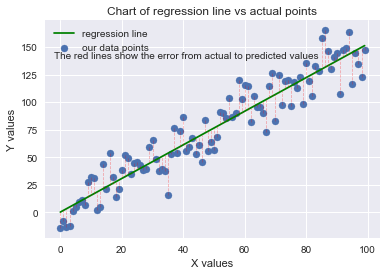

In [30]:
epochs = 15
learning_rate = 0.0001

m, b = 0, 0
n = len(x_points)
m_and_b_hist = [[0,0]]

for epoch in range(epochs):
    m_gradient = 0
    b_gradient = 0
    preds = predict(x_points, m, b)
    for i in range(n):
        error = y_points[i] - (m*x_points[i] + b) # shouldn't really matter whether its the other way
        m_gradient += -x_points[i] * error
        b_gradient += -error
    
    m -= (2/n) * m_gradient * learning_rate
    b -= (2/n) * b_gradient * learning_rate
    m_and_b_hist.append([m,b])
    
    print(f"Epoch {epoch:2}, Cost {regression_error(m,b, x_points, y_points):10,.2f}\
            Gradient: {m:.3f}, Intercept: {b:.4f}")

print(f"---Final Values---")
print(f"Gradient: {m:.3f}, Intercept: {b:.4f}, Cost: {regression_error(m, b, x_points, y_points):,.3f}")
plot(x_points, y_points, predict(x_points, m, b))    

So this solution has almost the same cost than the one above, but the y-intercept is an order of magnitude lower than the numpy solution. This is becuase gradient descent finds a comparable solution not necessarily the optimal one.

# Animation

An attempt to show the gradient descent as it happens in an animation

In [35]:
all_the_y = np.array([predict(x_points, m,b) for m,b in m_and_b_hist])
all_the_y.shape

(16, 100)

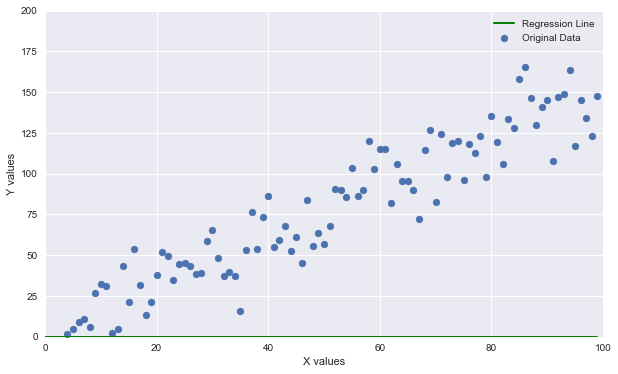

In [65]:
# need fig to pass to the animation function
fig, ax = plt.subplots(figsize=(10, 6))

# fixing the axis size makes sure the animation doesn't jump around as
# matplotlib changes the plot size as data changes
ax.set(xlim=(0, 100), ylim=(0, 200))

x = x_points
y = np.array([predict(x_points, m,b) for m,b in m_and_b_hist])

line, = ax.plot(x, y[0], lw=2, color="g", label="Regression Line")
plt.scatter(x, y_points, label="Original Data")

def animate(i):
    line.set_ydata(y[i])

plt.xlabel("X values"), plt.ylabel("Y values")
plt.legend()
    
anim = FuncAnimation(
    fig, animate, interval=1000, frames=len(y))

HTML(anim.to_html5_video())

The animataion (or the printouts above) make it clear the gradient descent 